### Preliminary Actions 1: Read the data set from csv file. Create dummy variables for the nine levels of rural_urbal_continuum_codes (RUCC) and the four geographical regions. Create the predictors data frame and the target variable series.

In [1]:
# There are many warnings regarding the updates in the future releases of the libraries. Ignore them.
import warnings
warnings.filterwarnings("ignore")

# Set the backend of matplotlib to inline
%matplotlib inline

# Improt necessary libraries
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns

# Set style and context
sns.set_style('whitegrid')
sns.set_context('talk')

# Load the data set
df = pd.read_csv('wrangled_data.csv')
# Remove the .0 after RUCC numbers and transform it to string
df.RUCC=df.RUCC.astype('int').astype('str')

# define the predictors dataframe and the target variable series
X = df.drop(['state','county','poverty'],axis=1)
y = df['poverty']

# Create dummy variables for region and RUCC
X=pd.get_dummies(X)

# drop one column of dummy variable from each categorical variable to avoid collinearity
# In Story Telling section, it was shown that the correlations between poverty and majority of rural urban continuum codes 
# i.e. all except RUCC 1 and 6, are close to each other . Therefore, any of these seven RUCC could be picked as the base 
# to simplify the interpretation. I pick RUCC 9 and remove it
# In Story Telling section, it was shown that the correlations between poverty and the four geographical regions are different
# from each other. Therefore, any of them could be picked as the base. I pick Midwest and remove it
# Also, the sum of the four education levels is 100 and one of them must be removed to avoid collinearity.
# In Story Telling section, it was shown that the correlations between poverty and the four education levels are different
# from each other. Therefore, any of them could be picked as the base. I pick bachelors/higher and remove it

X.drop(['region_Midwest','RUCC_9','bachelors/higher'],axis=1,inplace=True)

#Print the first five rows of X
X.head()

,less_than_high_school,high_school_diploma,college/associate_degree,unemployment,region_Northeast,region_South,region_West,RUCC_1,RUCC_2,RUCC_3,RUCC_4,RUCC_5,RUCC_6,RUCC_7,RUCC_8
0,12.417,34.331,28.660,5.3,0,1,0,0,1,0,0,0,0,0,0
1,9.972,28.692,31.788,5.4,0,1,0,0,0,1,0,0,0,0,0
2,26.236,34.927,25.969,8.6,0,1,0,0,0,0,0,0,1,0,0
3,19.302,41.816,26.883,6.6,0,1,0,1,0,0,0,0,0,0,0
4,19.969,32.942,34.039,5.5,0,1,0,1,0,0,0,0,0,0,0


### Step 1: Build a linear model: there are 15 predictors and more than 3000 samples, and therefore,the model can be built based on all predictors. Then, run 5-fold cross-validation and average the scores. At the end, fit the linear model on the entire dataset and measure its R-squared

In [2]:
# Build the linear model 
model = LinearRegression()

# Run cross-validation and print the average of scores
scores = cross_val_score(model,X,y,cv=5)
print('The average of 5-fold cross validation scores for the linear model is ', np.round(np.mean(scores),3))

# Fit the model on the entire data and print its R-squared
model.fit(X,y)
print ('The R-squared of the linear model fitted on the entire dataset is ',np.round(model.score(X,y),3))

The average of 5-fold cross validation scores for the linear model is  0.525
The R-squared of the linear model fitted on the entire dataset is  0.596


### Observation
#### The linear model does not have a high R-squared. It also does not have a good performance in prediction since the average of cross-validation scores is not high. 

### Before examining other models in Step 4 and beyond, I will simplify the linear model and investigate the assumptions related to linear models (linearity of the model, and independence and normal distribution of residuals) in Steps 2 and 3, respectively.

### Step 2: Bulid the linear model again with OLS command and simplify the model by removing the predictors with p-values lower than 0.001. Then fit the linear model to the dataset with reduced number of predictors and measure its R-squared. At the end, print the summary of the model.

In [63]:
# Build the linear model with OLS command
X2 = sm.add_constant(X) #OLS by default does not have intercept
model = sm.OLS(y,X2).fit()

# Remove predcitors with p-value less than 0.001
X_new = X2.loc[:,model.pvalues[model.pvalues <0.001].index]

# fit the model on the dataset with reduced number of predictors
model = sm.OLS(y,X_new).fit()

# print summary of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                poverty   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     574.4
Date:                Fri, 21 Dec 2018   Prob (F-statistic):               0.00
Time:                        09:08:16   Log-Likelihood:                -8811.7
No. Observations:                3141   AIC:                         1.764e+04
Df Residuals:                    3132   BIC:                         1.770e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        6.0101      0.660      9.101      0.000       4.715       7.305
less_than_high_school        0.3980      0.016     24.697      0.000       0.366       0.430
college/associate_degree    -0.0464      0.017     -2.767      0.006      -0.079      -0.014
unemployment                 1.1141      0.043     25.813      0.000       1.029       1.199
region_South                 1.4758      0.178      8.298      0.000       1.127       1.824
RUCC_1                      -3.4651      0.232    -14.962      0.000      -3.919      -3.011
RUCC_2                      -1.4689      0.237     -6.203      0.000      -1.933      -1.005
RUCC_3                      -0.7602      0.241     -3.157      0.002      -1.232      -0.288
RUCC_6                      -0.5610      0.199     -2.819      0.005      -0.951      -0.171
==============================================================================
Omnibus:                      734.425   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4492.331
Skew:                           0.966   Prob(JB):                         0.00
Kurtosis:                       8.531   Cond. No.                         320.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### After removing the predictors with low p-values from the original predictors and refitting the model, the new model again has some predictors with p-values higher than 0.001. They need to be removed

In [64]:
# Remove predcitors with p-value less than 0.001
X_new = X2.loc[:,model.pvalues[model.pvalues <0.001].index]

# fit the model on the dataset with reduced number of predictors
model = sm.OLS(y,X_new).fit()

# print summary of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                poverty   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     909.7
Date:                Fri, 21 Dec 2018   Prob (F-statistic):               0.00
Time:                        09:08:34   Log-Likelihood:                -8822.0
No. Observations:                3141   AIC:                         1.766e+04
Df Residuals:                    3135   BIC:                         1.769e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.0600      0.238     17.051      0.000       3.593       4.527
less_than_high_school     0.4170      0.015     28.130      0.000       0.388       0.446
unemployment              1.1132      0.043     25.728      0.000       1.028       1.198
region_South              1.4724      0.175      8.398      0.000       1.129       1.816
RUCC_1                   -3.0932      0.217    -14.260      0.000      -3.518      -2.668
RUCC_2                   -1.1941      0.226     -5.279      0.000      -1.638      -0.751
==============================================================================
Omnibus:                      735.685   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4604.115
Skew:                           0.961   Prob(JB):                         0.00
Kurtosis:                       8.611   Cond. No.                         64.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Observation
#### The linear model is significantly simplified because the number of predictors have dropped from 15 to 5. The R-squared of the simplified linear model which is 0.592 has only dropped by 0.004 compared to the original model which is 0.596.

### Step 3: Examine residual vs fitted value plot and quantile-quantile plot to examine the adherence of the simplified model to linearity, independent residuals, and normal distribution of residuals.

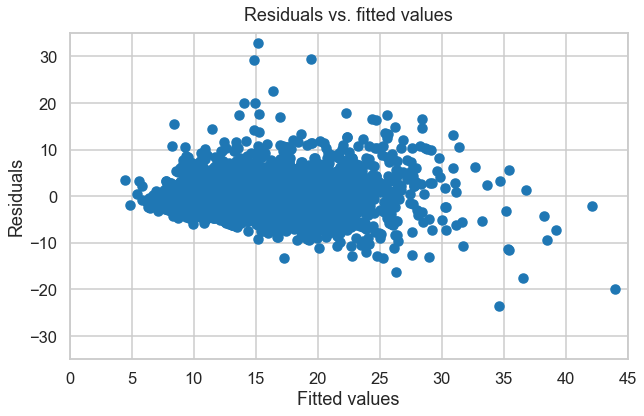

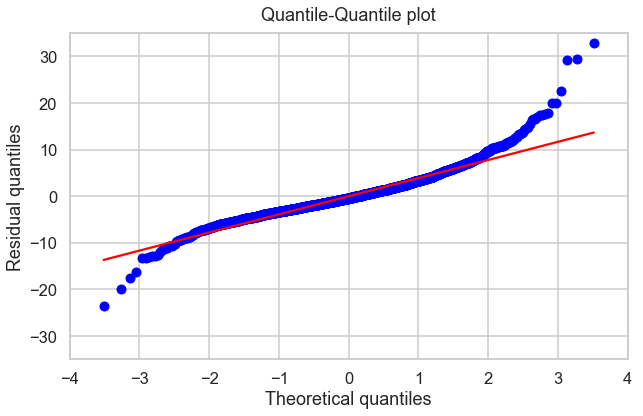

In [65]:
# Plot residuals vs. fitted values
figure,ax = plt.subplots(figsize=(10,6))
ax.scatter(model.fittedvalues,model.resid)
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals');
ax.set_title('Residuals vs. fitted values',y=1.02)
ax.axis([0,45,-35,35])

# Plot quantile plot
figure,ax = plt.subplots(figsize=(10,6))
stats.probplot(model.resid,plot=ax)
ax.set_ylabel('Residual quantiles')
ax.set_title('Quantile-Quantile plot',y=1.02)
ax.axis([-4,4,-35,35])

# Show plots
plt.show()

### Observations

#### 1) residual vs. fitted values
#### 1.a) Linearity: the residuals bounce randomly around the 0 line. This suggests the assumption that the relationship is linear is reasonable. 
#### 1.b) Independent residuals: the residuals roughly form a horizontal band around the 0 line. This suggests the variance of the residuals are quite equal and the assumption that the residuals are independent is reasonable.

#### 2) Quantile-Quantile plot: The plot shows the distribution of the residuals is heavy tailed, but, it is still close to the normal distribution

### Step 4: Add interaction between predictors and nonlinear terms to the linear model. Then, run 5-fold cross-validation and average the scores. At the end, fit the linear model on the entire dataset and measure its R-squared

In [92]:
# Import necessary libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Create linear regression and polynomial features, and use pipeline
linear = LinearRegression()
poly = PolynomialFeatures(degree = 2, interaction_only = False)
pipeline = make_pipeline(poly, linear)

# Run cross-validation and print the results
scores = cross_val_score(pipeline,X,y,cv=5)
print('The average of 5-fold cross validation scores for the linear model which includes interaction between predictors is '\
,np.round(np.mean(scores),3))

# Fit the model on the entire data and print its R-squared
pipeline.fit(X,y)
print ('The R-squared of the linear model with interaction fitted on the entire dataset is ',np.round(pipeline.score(X,y),3))

The average of 5-fold cross validation scores for the linear model which includes interaction between predictors is  0.564
The R-squared of the linear model with interaction fitted on the entire dataset is  0.671


### Observation
#### Both R-squared of the linear model and its performance in prediction (average of cross-validation scores) have slightly improved after adding nonlinear and interaction terms.

### Step 5: Random Forest: first, build a random forest with no parameter tuning, run 5-fold cross-validation, and average the scores. Then, divide the dataset into train and test test and tune some parameters of the model based on the train set. At the end, the performance of model in predicting the target value of the test set will be computed. 

In [3]:
#Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Build the model without parameter tuning, run cross-validation, and average the scores
forest = RandomForestRegressor(random_state=21)
scores = cross_val_score(forest,X,y,cv=5)
print('The average of 5-fold cross-validation for the random forest without parameter tuning is %.3f'%np.mean(scores))

C:\Users\moein\Miniconda3\envs\newpy36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


The average of 5-fold cross-validation for the random forest without parameter tuning is 0.512


In [4]:
# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=21)

# Define a function which receives model and parameters as inputs, tune parameters 
# and prints best parameters and the test set score
def tuning(model,parameters):
    model = GridSearchCV(model,param_grid=parameters,cv=5)
    model.fit(X_train,y_train)
    print('The test set score after tuning parameters is ',np.round(model.score(X_test,y_test),3))
    print('The best parameters are: ',model.best_params_)

In [76]:
# Build the random forest, Tune its parameters and find the test set score with the new model
forest = RandomForestRegressor(random_state=21)
parameters = {'n_estimators':[10,50,100],\
              'criterion': ['mse','mae'],\
             'min_samples_leaf':[5,7,10],\
             'max_features':['auto','sqrt','log2']}
tuning(forest,parameters)

The test set score after tuning parameters is  0.627
The best parameters are:  {'criterion': 'mse', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}


#### Going below 5 samples per leaf may result in overfitting to the training set. A couple of more n_estimators is tested

In [120]:
# Build new random forest, tune n_estimators and min_samples_leaf, and find the test set score with the new model
forest = RandomForestRegressor(criterion = 'mse', max_features = 'sqrt', min_samples_leaf = 5, random_state=21)
parameters = {'n_estimators':[100,300,500]}
tuning(forest,parameters)

The test set score after tuning parameters is  0.63
The best parameters are:  {'n_estimators': 300}


#### The test score has slightly improved. At the end find the R-squared of the model fitted on the entire dataset

In [153]:
#Build the random forest with tuned parameters
model = RandomForestRegressor(n_estimators = 300, min_samples_leaf = 5,criterion = 'mse', max_features = 'sqrt', random_state=21)

#Fit the model to the entire dataset and find the R-squared 
model.fit(X,y)
print('The R-squared of the random forest fitted on the entire dataset is ',np.round(model.score(X,y),3))

The R-squared of the random forest fitted on the entire dataset is  0.747


In [168]:
print(type(model.score(X,y)))
print(type(np.round(model.score(X,y),3).astype(np.float)))

<class 'numpy.float64'>
<class 'numpy.float64'>


### Observation
#### 1) The performance of the the random forest model in prediction after tuning its parameters has improved compared to the linear model with interaction and nonlinear terms because the test set score of the random forest model is 0.630 but the average of 5-fold cross-validation scores of the linear model is 0.564.
#### 2) The R-sqaured of the the random forest model fitted on the entire dataset is 0.747 which is more than R-squared of the linear model which is 0.671.

### Step 6: Improve random forest performance by adding one predictor. First split data into train and test set. Then concatenate predictors and target variable in each set. Next, cluster the concatenated train set and predict clusters for the concatenated test set. Then, add cluster column as the new predictor to predictors dataframe in each train and test set. Next, bulid the model based on the new predictors dataframe in train set, tune the number of clusters as well as the parameters of random forest. At the end, the performance of model in prediction by predicting the target value of the test set.

In [6]:
# Import Kmeans
from sklearn.cluster import KMeans

#Define clustering function
def clustering(X,y,n_cluster):
    # Split the dataset to train and test set
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=21)
    # Concat predictors and target variable of the train set
    Xy_train = pd.concat([X_train,y_train],axis=1)
    # Builder the KMeans cluster and fit it to train set
    kmeans = KMeans(n_clusters=50,random_state=21,algorithm='full')
    kmeans.fit(Xy_train)
    # Build the new predictor for the train set and concatenate it to the predictors dataframe of the train set
    new_column_train = kmeans.predict(Xy_train)
    X_train.reset_index(inplace=True,drop=True)
    X_train_extended = pd.concat([X_train,pd.DataFrame(new_column_train,columns=['cluster'])],axis=1)
    # Concatenate predictors and target variable of the train set
    Xy_test = pd.concat([X_test,y_test],axis=1)
    # Build the new predictor for the test set and concatenate it to the predictors dataframe of the test set
    new_column_test = kmeans.predict(Xy_test)
    X_test.reset_index(inplace=True,drop=True)
    X_test_extended = pd.concat([X_test,pd.DataFrame(new_column_test,columns=['cluster'])],axis=1)
    return X_train_extended,X_test_extended,y_train,y_test

In [25]:
# Import Kfold
from sklearn.model_selection import KFold
def cluster_forest_SearchCV(cluster_numbers,parameters,X,y):
    df = pd.DataFrame(index=np.arange(len(cluster_numbers)),columns=['number_of_clusters','best_parameters','score'])
    for idx,n_cluster in enumerate(cluster_numbers):
        X_train_extended,X_test_extended,y_train,y_test = clustering(X,y,n_cluster)
        forest = RandomForestRegressor(criterion = 'mse', max_features = 'sqrt', random_state=21)
        model = GridSearchCV(forest,param_grid=parameters,cv=5)
        model.fit(X_train_extended,y_train)
        score = np.round(model.score(X_test_extended,y_test),3)
        best_parameters = model.best_params_
        df.loc[idx] = [n_cluster,best_parameters,score]
        print(n_cluster,' ',idx)
    df.score = df.score.astype(np.float)
    best_score_index = df.score.argmax()
    print('Best test set score is ',df.loc[best_score_index,'score'])
    print('Number of clusters for the best test set score is ',df.loc[best_score_index,'number_of_clusters'])
    print('Parameters for the best test set score is ',df.loc[best_score_index,'best_parameters'])
    return df

In [26]:
cluster_numbers=[5,10,50]
parameters = {'n_estimators':[10,50],\
             'min_samples_leaf':[5,7,10]}
dff=cluster_forest_SearchCV(cluster_numbers,parameters,X,y)


5   0
10   1
50   2
Best test set score is  0.702
Number of clusters for the best test set score is  5
Parameters for the best test set score is  {'min_samples_leaf': 5, 'n_estimators': 50}


In [34]:
kf = KFold(n_splits = 5)
for train_index, test_index in kf.split(X):
    print(train_index.shape)
    print(test_index.shape)

(2512,)
(629,)
(2513,)
(628,)
(2513,)
(628,)
(2513,)
(628,)
(2513,)
(628,)


In [35]:
2513/3141

0.8000636739891754

In [23]:
X_train_extended,X_test_extended,y_train,y_test = clustering(X,y,50)
forest = RandomForestRegressor(criterion = 'mse', max_features = 'sqrt', min_samples_leaf = 1, random_state=21)
parameters = {'n_estimators':[100,200,300,400]}
model = GridSearchCV(forest,param_grid=parameters,cv=5)
model.fit(X_train_extended,y_train)
print('The test set score after tuning parameters is ',np.round(model.score(X_test_extended,y_test),3))
print('The best parameters are: ',model.best_params_)
print('The best score is: ',model.best_score_)

The test set score after tuning parameters is  0.735
The best parameters are:  {'n_estimators': 200}
The best score is:  0.7322848043751303


In [22]:
Xy = pd.concat([X,y],axis=1)
kmeans = KMeans(n_clusters=50,random_state=21,algorithm='full')
new_column = kmeans.fit_predict(Xy)
X1 = X.reset_index(drop=True, inplace = True) 
X_extended = pd.concat([X1,pd.DataFrame(new_column,columns=['cluster'])],axis=1)
forest = RandomForestRegressor(criterion = 'mse', max_features = 'sqrt', min_samples_leaf = 1, random_state=21)
forest.fit(X_extended,y)
forest.score(X_extended,y)

0.882601193494756

In [138]:
dff=pd.read_csv('wrangled_data.csv')
dff['bachelors/higher'].argmax()

2924

In [139]:
dff.loc[2924]

state                                      VA
county                      Falls Church city
region                                  South
RUCC                                        1
less_than_high_school                   2.048
high_school_diploma                     6.464
college/associate_degree               11.278
bachelors/higher                        80.21
poverty                                     4
unemployment                              2.7
Name: 2924, dtype: object

In [136]:
dff.describe()

,RUCC,less_than_high_school,high_school_diploma,college/associate_degree,bachelors/higher,poverty,unemployment
count,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000
mean,5.009233,14.191065,34.580418,30.435074,20.793442,15.929322,5.259280
std,2.708605,6.542345,7.077880,5.126994,9.143124,6.284708,1.889193
min,1.000000,1.279000,6.464000,11.278000,2.985000,3.000000,1.700000
25%,2.000000,9.274000,30.150000,26.915000,14.429000,11.000000,4.000000
50%,6.000000,12.752000,34.926000,30.490000,18.544000,15.000000,5.000000
75%,7.000000,18.289000,39.608000,33.922000,24.704000,19.000000,6.200000
max,9.000000,51.479000,54.642000,47.428000,80.210000,49.000000,23.500000


In [97]:
# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=21)
from sklearn.svm import SVR
svr = SVR()
scores = cross_val_score(svr,X,y,cv=5)
print(np.mean(scores))

0.44265162485732734


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=21)
svr = SVR(kernel='linear')
parameters = {'C':[2,5,10],\
             'epsilon':[0.5,0.8]}
model = GridSearchCV(svr,param_grid = parameters, cv=5)
model.fit(X_train_extended,y_train)
print('The test set score after tuning parameters is ',np.round(model.score(X_test_extended,y_test),3))
print('The best parameters are: ',model.best_params_)

The test set score after tuning parameters is  0.575
The best parameters are:  {'C': 10, 'epsilon': 0.8}
